# IMPORTING LIB

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import pyroomacoustics as pra

from sklearn.decomposition import FastICA

from scipy.io import wavfile
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull

import mir_eval


# SOURCE GENERATION

In [2]:
# Set the sampling frequency (assumed to be constant for all files)
fs = 44100

# Desired duration in seconds for all samples
dur_seconds = 5

# Calculate the number of samples required to achieve the desired duration
dur_samples = int(dur_seconds * fs)

# Define the folder path where the audio files are located
folder_path = "audio/"

# Find all the audio files in the folder
files_name = [file for file in os.listdir(folder_path) if file.endswith(".wav")]

# Create an empty numpy array to store the normalized and trimmed audio samples
sources_array = np.empty((len(files_name), dur_samples))

# Iterate over each audio file
for idx, file in enumerate(files_name):
    # Load the file path for the current audio file
    file_path = os.path.join(folder_path, file)
    
    # Read the audio file
    _, audio = wavfile.read(file_path)  # Here, we're not using the sampling frequency returned by wavfile.read as we've assumed it's constant

    if len(audio) > dur_samples:
        cut_audio = audio[:dur_samples]
        
        # Normalize the audio sample
        cut_audio = cut_audio / abs(cut_audio).max()
        sources_array[idx] = cut_audio

    else:
        # Normalize the audio sample
        audio = audio / abs(audio).max()
        sources_array[idx, :len(audio)] = audio

# Ensure all rows have the same length (in case some files were shorter than others)
min_length = min(len(audio) for audio in sources_array)
sources_arrays = sources_array[:, :min_length]


/var/folders/4w/35nmcx750fl0p5v_tymchpx40000gp/T/ipykernel_10470/2512917357.py:25: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, audio = wavfile.read(file_path)  # Here, we're not using the sampling frequency returned by wavfile.read as we've assumed it's constant


In [3]:
# Iterate over each audio file and its corresponding sample
for file, sample in zip(files_name, sources_array):
    # Print the file name
    print("Playing:", file)
    
    # Play the audio sample
    display(Audio(data=sample, rate=fs, autoplay=False))

Playing: voice2.wav


Playing: voice3.wav


Playing: voice1.wav


Playing: piano2.wav


Playing: piano1.wav


In [4]:
# Define the indices of the files you want to inspect (assuming files are 0-indexed)
choosen_indx = [0, 4]  # Replace with the indices of files 1 and 4
N = len(choosen_indx)

sources = sources_arrays[choosen_indx]

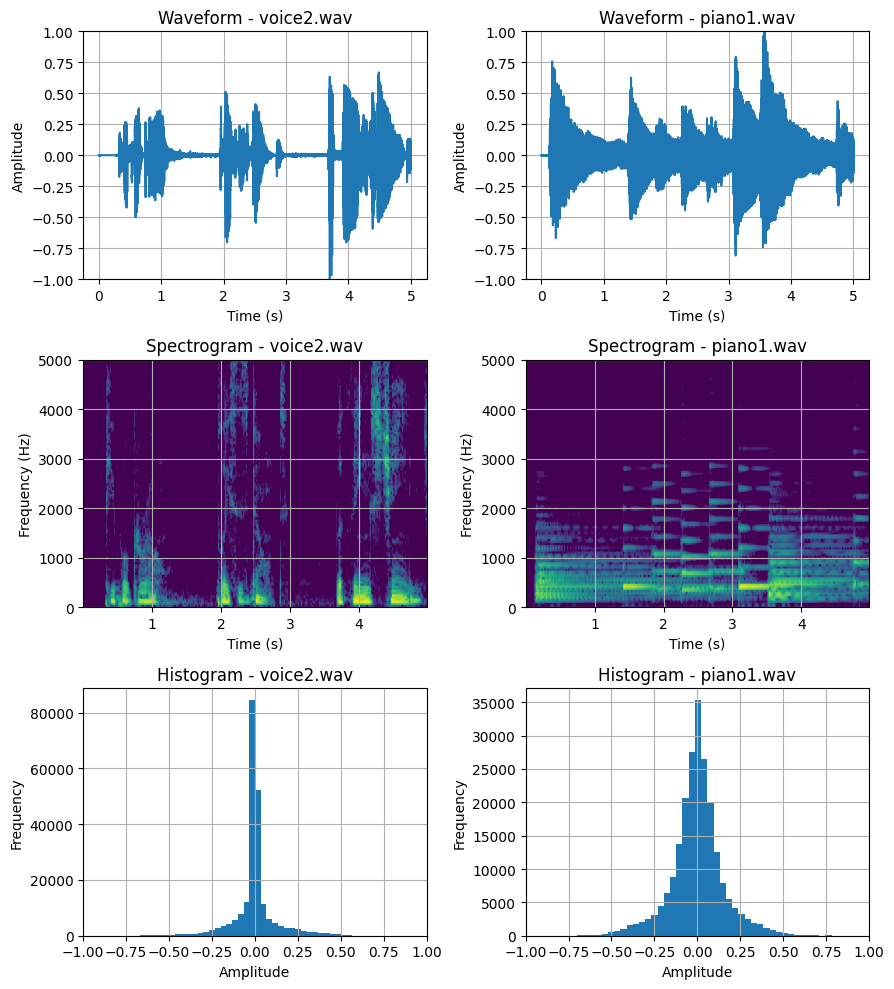

In [5]:
# Set up subplots with 2 columns and 3 rows
plt.figure(figsize=(9, 5*N))

for i in np.arange(N):
    # Get the audio sample and file name
    file_name = files_name[choosen_indx[i]]
    
    # Plot the waveform
    plt.subplot(3, 2, i+1)
    plt.plot(np.arange(len(sources[i])) / fs, sources[i])
    plt.title('Waveform - ' + file_name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(-1, 1)  # Set y-axis limits
    plt.grid(True)  # Add gridlines
    
    # Plot the spectrogram
    plt.subplot(3, 2, i+3)
    plt.specgram(sources[i], NFFT=1024, Fs=fs, cmap='viridis', vmin=-80)  # Adjusted parameters
    plt.title('Spectrogram - ' + file_name)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 5000)  # Set y-axis limits
    plt.grid(True)  # Add gridlines
    
    # Plot the histogram
    plt.subplot(3, 2, i+5)
    plt.hist(sources[i], bins=50)
    plt.title('Histogram - ' + file_name)
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.xlim(-1, 1)  # Set x-axis limits
    plt.grid(True)  # Add gridlines

plt.tight_layout()
plt.show()


# AUDIO RECORDING SIMULATION

## ROOM CREATION

Text(0.5, 0, 'Z')

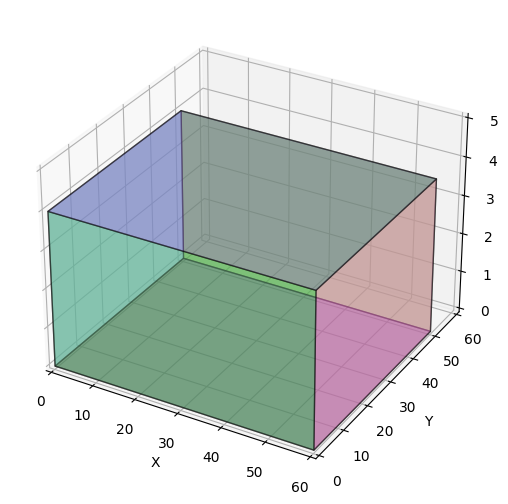

In [5]:
# Define the corners of a 2D room as an array of (x, y) coordinates
corners = np.array([[0,0], [0,50], [60,50], [60,0]]).T  # [x,y]

# Create a 2D room object from the given corners
# max_order: Maximum reflection order for ray tracing
# materials: Defines the acoustic properties of the walls (absorption coefficient, reflection coefficient)
room = pra.Room.from_corners(corners, max_order=3, materials=pra.Material(0.2, 0.15), ray_tracing=True, air_absorption=True, fs=fs)

# Set the parameters for ray tracing
# receiver_radius: Radius of the receiver for computing the visibility polygon
# n_rays: Number of rays to use for ray tracing
# energy_thres: Threshold energy for ray termination
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# Extrude the 2D room to create a 3D room with a specified height
# materials: Defines the acoustic properties of the walls in 3D (absorption coefficient, reflection coefficient)
room.extrude(4., materials=pra.Material(0.2, 0.15))

# Plot the room
fig, ax = room.plot()
ax.set_xlim([0, 60])  # Set x-axis limits
ax.set_ylim([0, 60])  # Set y-axis limits
ax.set_zlim([0, 5])  # Set z-axis limits
ax.set_xlabel('X')  # Label for x-axis
ax.set_ylabel('Y')  # Label for y-axis
ax.set_zlabel('Z')  # Label for z-axis

Text(0.5, 0, 'Z')

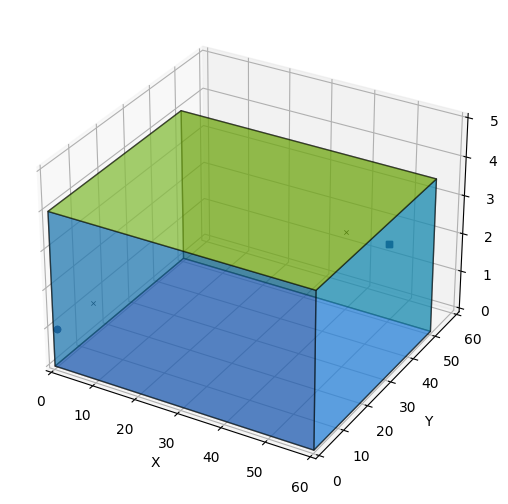

In [6]:
# Define the locations of sources within the room and their corresponding signals
sources_info = {
    "source1": {"loc": np.array([1., 0., 1.]), "signal": sources[0]},  # Location and signal for source 1
    "source2": {"loc": np.array([50., 50., 2.]), "signal": sources[1]}  # Location and signal for source 2
}


# Add sources to the room
for name, info in sources_info.items():
    room.add_source(info["loc"], signal=info["signal"])  # Add source with specified location and signal


# Define the positions of two microphones in 3D space [[x1, x2..],[y1, y2..],[z1, z2..]]
mic_positions = np.array([[10., 40.], [0., 50.], [2., 2.]])  # Microphone positions

# Add the microphone array to the room
room.add_microphone_array(pra.MicrophoneArray(mic_positions, fs))  # Add microphone array with specified positions

# Plot the room with sources and microphone array
fig, ax = room.plot()  # Plot the room
ax.set_xlim([0, 60])  # Set x-axis limits for the plot
ax.set_ylim([0, 60])  # Set y-axis limits for the plot
ax.set_zlim([0, 5])  # Set z-axis limits for the plot
ax.set_xlabel('X')  # Label for x-axis
ax.set_ylabel('Y')  # Label for y-axis
ax.set_zlabel('Z')  # Label for z-axis


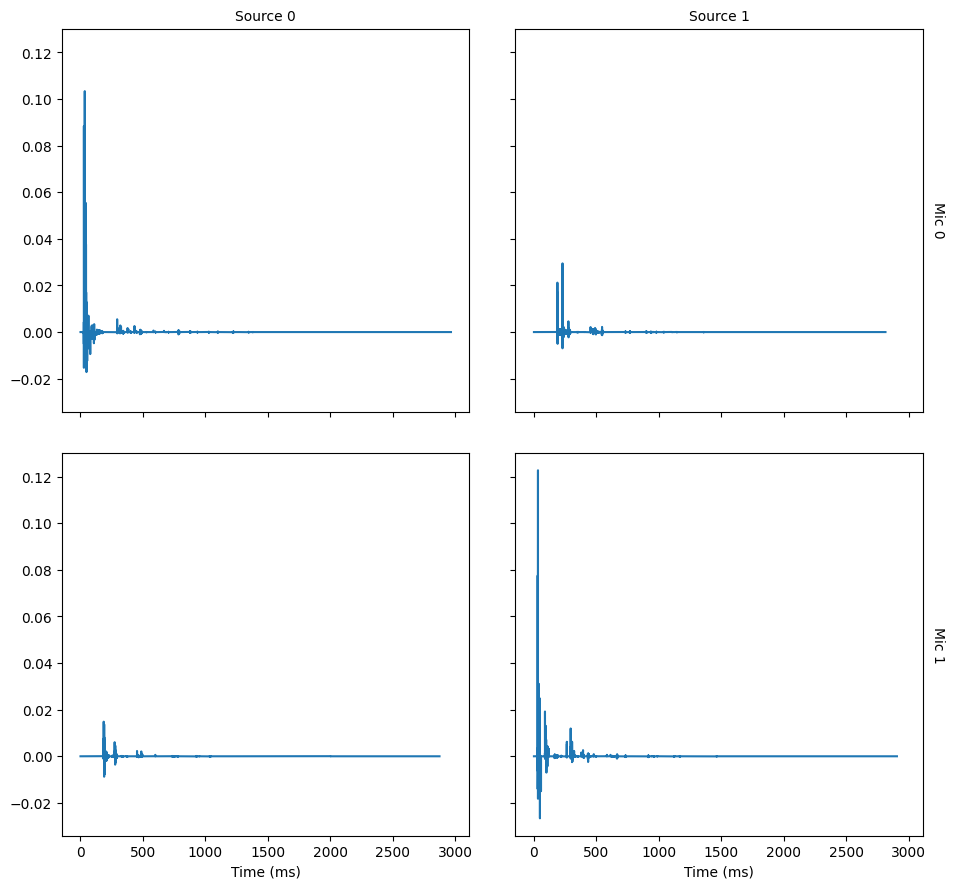

In [7]:
# Plot the room impulse response (RIR)
room.plot_rir()

# Get the current figure
fig = plt.gcf()

# Set the size of the figure for better visualization
fig.set_size_inches(10, 10)

In [8]:
room.simulate()
signal_rec = room.mic_array.signals

## INSPECT RECORDINGS

In [9]:
# Simulated propagation and play audio
for i in range(N):
    # Separated sources by FastICA
    print(f'Simulated recording mic {i+1}:')
    display(Audio(signal_rec[i, :], rate=fs))

Simulated recording mic 1:


Simulated recording mic 2:


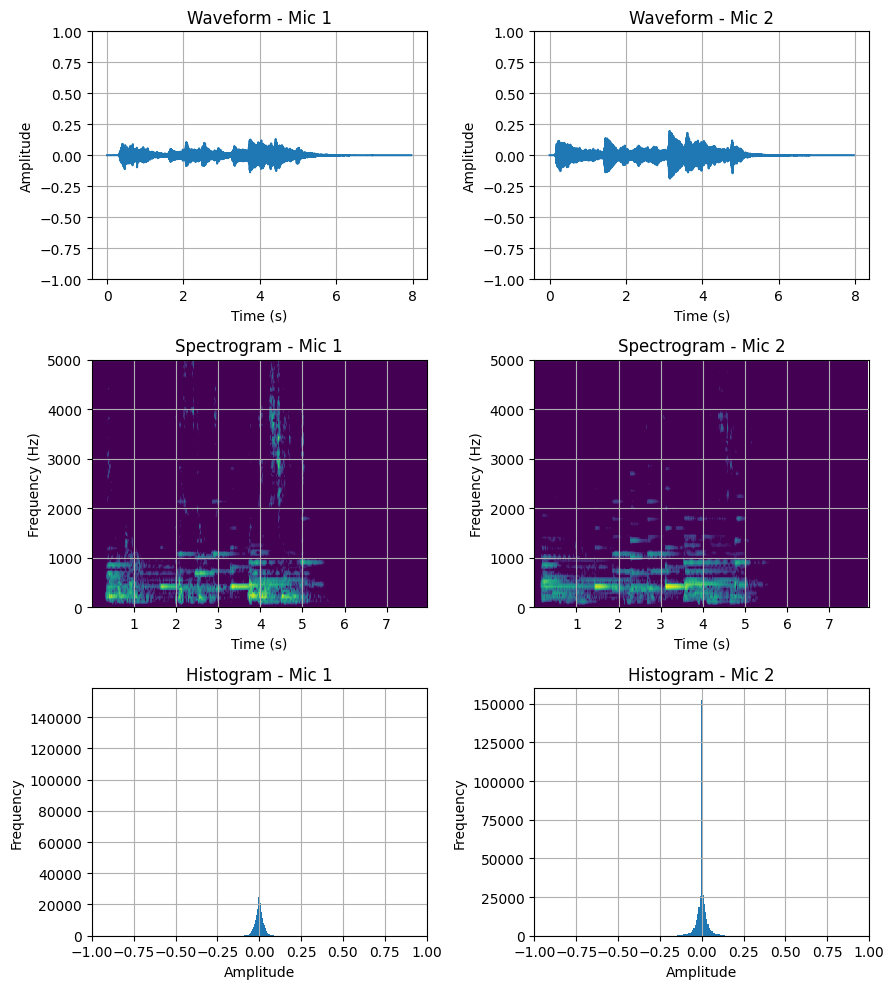

In [12]:
# Set up subplots with 2 columns and 3 rows
plt.figure(figsize=(9, 5*signal_rec.shape[0]))

for i in range(signal_rec.shape[0]):
    
    # Plot the waveform
    plt.subplot(3, 2, i+1)
    plt.plot(np.arange(len(signal_rec[i])) / fs, signal_rec[i])
    plt.title(f'Waveform - Mic {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim(-1, 1)  # Set y-axis limits
    plt.grid(True)  # Add gridlines
    
    # Plot the spectrogram
    plt.subplot(3, 2, i+3)
    plt.specgram(signal_rec[i], NFFT=1024, Fs=fs, cmap='viridis', vmin=-80)  # Adjusted parameters
    plt.title(f'Spectrogram - Mic {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 5000)  # Set y-axis limits
    plt.grid(True)  # Add gridlines
    
    # Plot the histogram
    plt.subplot(3, 2, i+5)
    plt.hist(signal_rec[i], bins=50)
    plt.title(f'Histogram - Mic {i+1}')
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.xlim(-1, 1)  # Set x-axis limits
    plt.grid(True)  # Add gridlines

plt.tight_layout()
plt.show()



# FastICA SOURCE SEPARATION

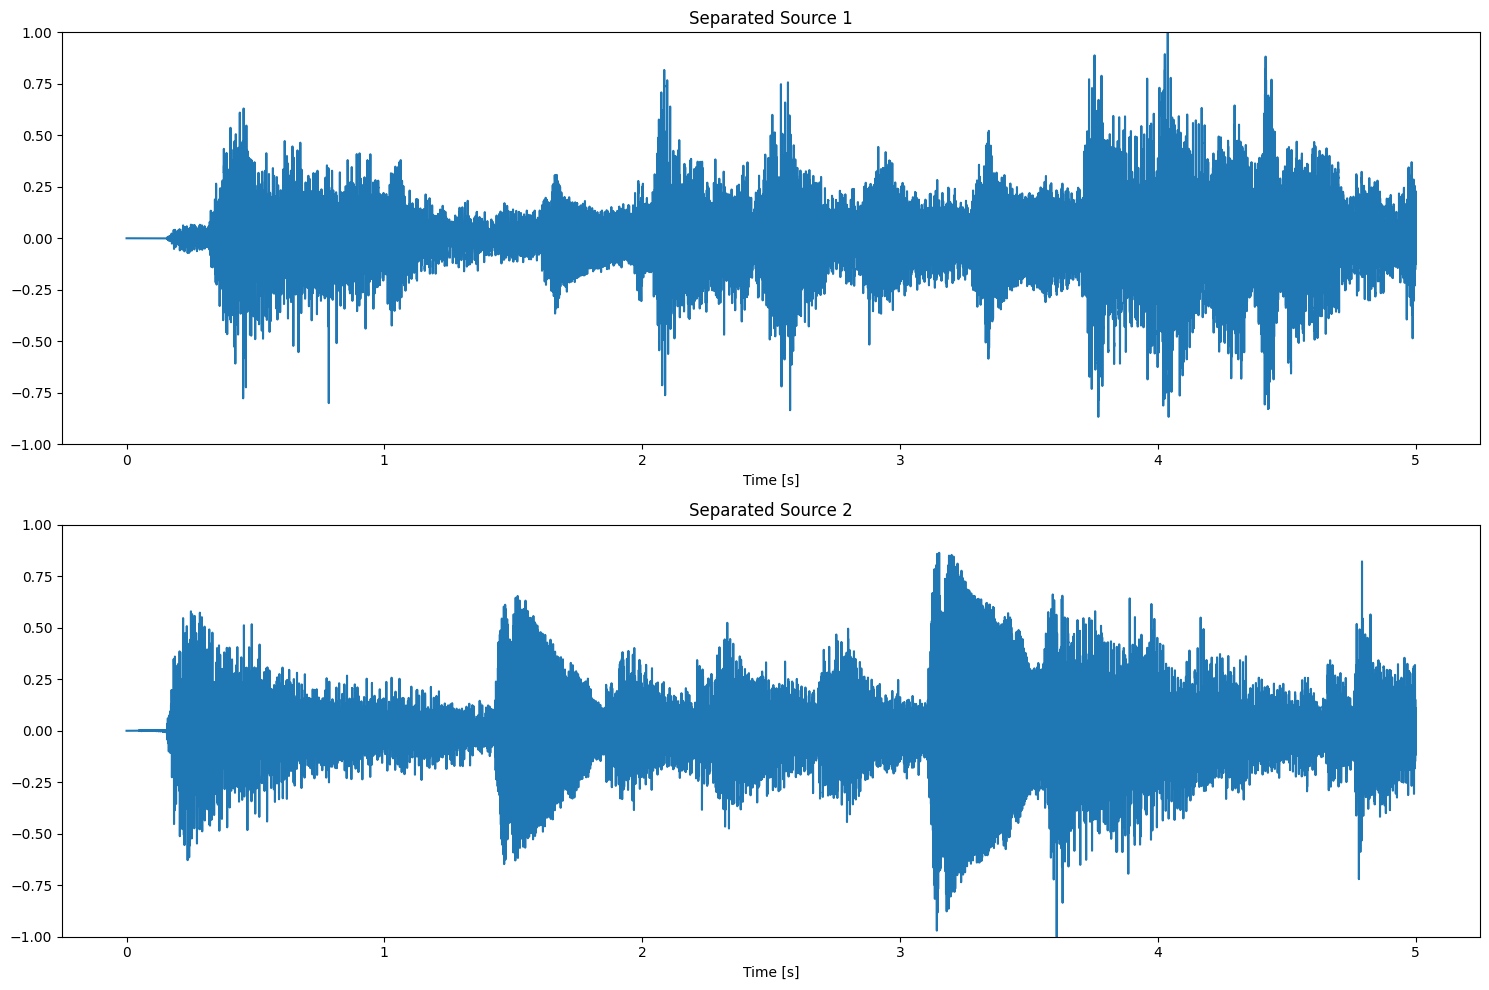

In [10]:
# Apply FastICA to separate the sources
ica = FastICA(n_components=N)
separated_sources_raw = (ica.fit_transform(signal_rec.T)).T

# Calculate the maximum absolute value in each signal
max_values = np.max(np.abs(separated_sources_raw), axis=1, keepdims=True)

# Normalize each signal by dividing by its maximum absolute value and clipping it to the same duration as the original signals
separated_sources = separated_sources_raw[:, :dur_samples] / max_values

# Create subplots
fig, axs = plt.subplots(N, 1, figsize=(15, 10))

# Plot waveforms
for i in range(N):
    axs[i].plot(np.arange(len(separated_sources[i])) / fs, separated_sources[i])
    axs[i].set_ylim(-1,1)
    axs[i].set_xlabel('Time [s]')
    axs[i].set_title(f'Separated Source {i+1}')

plt.tight_layout()
plt.show()

In [11]:
# Get the mixing matrix from the ICA transformation
ica_transformation = ica.mixing_

# Print the shape of the separated sources array and the mixing matrix
print("Shape of separated sources array:", separated_sources.shape)
print("\n ICA Mixing Matrix:")
print(ica_transformation)


Shape of separated sources array: (2, 220500)

 ICA Mixing Matrix:
[[ 0.01912332 -0.00256701]
 [-0.00010808 -0.02766678]]


In [12]:
for i in range(N):
    # Separated sources by FastICA
    print(f'Separated source {i+1}:')
    display(Audio(separated_sources[i, :], rate=fs))

Separated source 1:


Separated source 2:


# PERFORMANCE ANALYSIS

## Sorting and matching signals

In [16]:
# List to keep track of matched indices
matched_indices = []

# Make a copy of separated_sources
separated_sources_copy = np.copy(separated_sources)

# For each signal in sources
for source_signal in sources:
    # Calculate cosine similarity between the source signal and all signals in separated_sources_copy
    similarities = np.dot(source_signal, separated_sources_copy.T) / (np.linalg.norm(source_signal) * np.linalg.norm(separated_sources_copy, axis=1))
    
    # Find the index of the most similar signal
    best_match_index = np.argmax(np.abs(similarities))

    # If maximum similarity is zero, there's no match
    if similarities[best_match_index] == 0:
        matched_indices.append(None)  # No match
    else:
        # Add the index of the best match to the list of matched indices
        matched_indices.append(best_match_index)
        # Set the similarity of the best match to zero to avoid matching it again
        similarities[best_match_index] = 0

# Print the matched indices
print("Matched indices:", matched_indices)

# Sort separated_sources based on the matched indices
separated_sources_sorted = separated_sources[matched_indices]


Matched indices: [0, 1]


## BSS Metrics

These metrics are commonly used to evaluate the performance of source separation algorithms:

- SDR (Source-to-Distortion Ratio) measures the ratio of the energy of the true sources to the energy of the distortion caused by the separation process.

- SIR (Source-to-Interference Ratio) measures the ratio of the energy of the true sources to the energy of the interference caused by other sources.

- SAR (Source-to-Artifact Ratio) measures the ratio of the energy of the true sources to the energy of any artifacts introduced by the separation process.

These metrics provide insights into how well the source separation algorithm is performing in terms of preserving the original sources while minimizing interference and artifacts.

In [21]:
# Calculating BSS Evaluation Metrics

# Using mir_eval library to calculate SDR, SIR, SAR metrics
sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(sources, separated_sources_sorted)

# Printing the metrics
print("SDR:", sdr)  # Print the Source-to-Distortion Ratio (SDR) metric
print("SIR:", sir)  # Print the Source-to-Interference Ratio (SIR) metric
print("SAR:", sar)  # Print the Source-to-Artifact Ratio (SAR) metric

SDR: [-13.5478252    2.42328753]
SIR: [-1.43429222 27.89323615]
SAR: [-9.48592788  2.44267881]


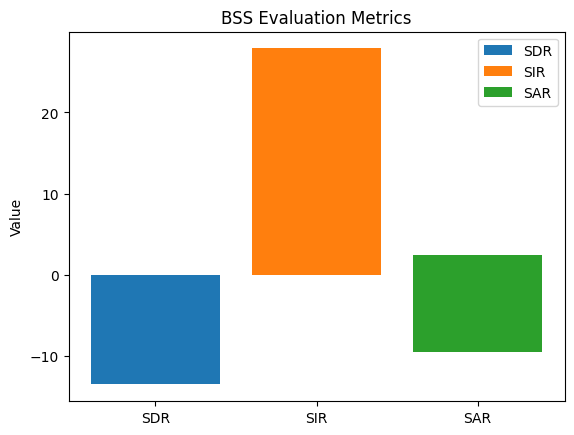

In [27]:
# Plotting the Evaluation Metrics

# List of evaluation metrics
metrics = ['SDR', 'SIR', 'SAR']

# Individual values of SDR, SIR, SAR metrics
values = [[-13.55, -1.43], [2.42, 27.89], [-9.49, 2.44]]

# Creating a bar plot for each metric
for metric, metric_values in zip(metrics, values):
    plt.bar(metric, metric_values, label=metric)

# Adding labels and title to the plot
plt.ylabel('Value')  # Label for the y-axis indicating individual metric values
plt.title('BSS Evaluation Metrics')  # Title of the plot
plt.legend()  # Display legend for metric labels

# Displaying the plot
plt.show()


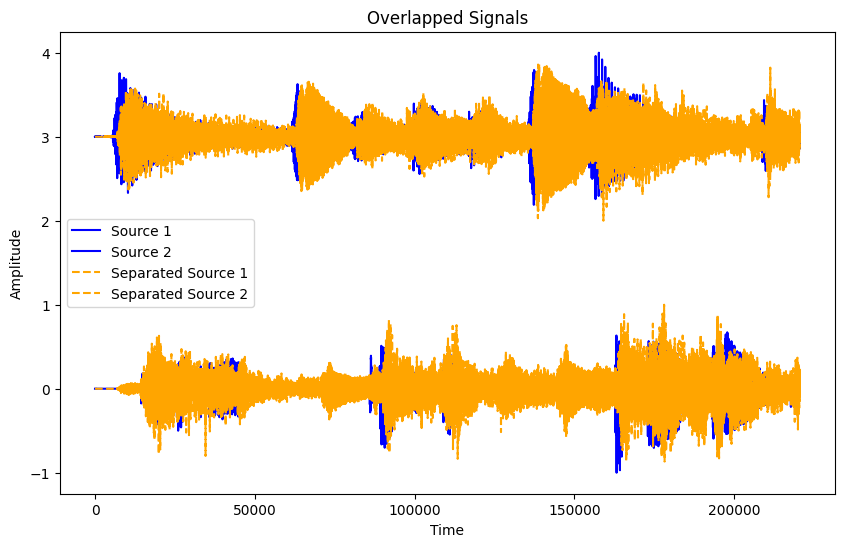

In [20]:
# Sovrapposizione dei segnali
plt.figure(figsize=(10, 6))

# Sovrapposizione dei segnali originali
for i, signal in enumerate(sources):
    plt.plot(signal + i * 3, label=f"Source {i + 1}", color='blue')

# Sovrapposizione dei segnali separati ordinati
for i, signal in enumerate(separated_sources_sorted):
    plt.plot(signal + i * 3, label=f"Separated Source {i + 1}", linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Overlapped Signals')
plt.legend()
plt.show()
